# 4.7 Design Deep Reinforcement Learning Agent

In this notebook we will consider an alternative question. Instead of asking how we can maximize profit on a single asset, we will ask whether a machine can pick the best assets given many selections. 

We will consider only price history data. We will provide 90 differenced timesteps on the minute interval period. We will choose the 500 stocks of the S&P 500. 

If our network can outperform the S&P 500 over the given time, we will consider it successful. 

In order to do this, we will need to perform the following steps:

- download datasets for all the stocks in the S&P 500. 
- format the data to represent the simulataneous movement of 500 stocks
- Build an environment to represent this movement
- Train a DQN to learn on it

#### Download datasets for all the stocks in the S&P 500.

In [1]:
import time
from IPython import display
from extract import extract_stock, extract_multi_periods, load_set
from transform import format_date
import pandas as pd 
import matplotlib.pyplot as plt
from sine_modules import *
from sklearn.linear_model import LinearRegression

In [2]:
from __future__ import absolute_import, division, print_function

import abc
import tensorflow as tf
import numpy as np
import base64
import IPython
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.trajectories import time_step as ts
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from tf_agents.agents.ddpg import critic_network
from tf_agents.agents.sac import sac_agent
from tf_agents.agents.sac import tanh_normal_projection_network
from tf_agents.experimental.train import actor
from tf_agents.experimental.train import learner
from tf_agents.experimental.train import triggers
from tf_agents.experimental.train.utils import spec_utils
from tf_agents.experimental.train.utils import strategy_utils
from tf_agents.experimental.train.utils import train_utils
from tf_agents.metrics import py_metrics
from tf_agents.networks import actor_distribution_network
from tf_agents.policies import greedy_policy
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_py_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
import reverb

tf.compat.v1.enable_v2_behavior()

In [3]:
tempdir = tempfile.gettempdir()

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
data_dir = './data/sp500/'
suffix = ''

In [5]:
f'{data_dir}spdfm.pickle'

'./data/sp500/spdfm.pickle'

In [6]:
spdfm = pd.read_pickle(f'{data_dir}spdfm.pickle')

In [7]:
spdfm.to_csv(f'{data_dir}spdfm.csv')

In [9]:
spdfm['MMM'][::-1]

datetime
2020-08-10 13:30:00    0.001384
2020-08-10 13:31:00    0.001664
2020-08-10 13:32:00   -0.000295
2020-08-10 13:33:00    0.000954
2020-08-10 13:34:00    0.001535
                         ...   
2020-09-04 19:55:00   -0.000362
2020-09-04 19:56:00   -0.000241
2020-09-04 19:57:00   -0.000664
2020-09-04 19:58:00   -0.000664
2020-09-04 19:59:00    0.000724
Name: MMM, Length: 7792, dtype: float64

In [10]:
X = spdfm['MMM'][::-1].to_numpy()

In [11]:
X.shape

(7792,)

In [12]:
del(spdfm)

#### Build an environment to represent this movement

In [24]:
class StockMarketEnv(py_environment.PyEnvironment):
    '''
    Observation: The observation should be a (90,505) matrix
    Action: A (505) vector with probabilties from 0 1, max 10 are encoded as 1, all others are 0
    Reward: dot product of the (505,1) top 10 choices with the next (1,505) returns
    '''
    def __init__(self, X):
        self._action_spec = array_spec.BoundedArraySpec(
                                    shape=(3,), dtype=np.float32, minimum=0, maximum=1, name='action')
        self._observation_spec = array_spec.BoundedArraySpec(
                                    shape=(90,), dtype=np.float32, minimum=-10, maximum=10 ,name='observation')
        self._X = X
        self._state = np.array(self._X[:90], dtype=np.float32)
        self._i = 0
        self._episode_ended = False
        
#         self._step_type_spec = array_spec.BoundedArraySpec(
#                                     shape=(1,), dtype=np.int32, name='step_type')
#         self._reward_spec = array_spec.BoundedArraySpec(
#                                     shape=(1,), dtype=np.float32, name='reward')
#         self._discount_spec = array_spec.BoundedArraySpec(
#                                     shape=(1,), dtype=np.float32, name='discount')

    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.array(self._X[:90], dtype=np.float32) ## input array
        self._i = 0
        self._episode_ended = False
        return ts.restart(self._state)

    def _step(self, action):
        '''
        Given a state array:
            - Choose the top ten stocks
            - Compute the reward by taking the dot product
            - Update the new state by taking the next timestep
            - Return the ts.transition(new_state, reward, discount=1)
        '''
        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()
        
        action_state = action.copy()
        action_state[action_state.argsort()[-1]] = 1
        
        mask = np.ones(action_state.shape, bool)
        mask[action_state.argsort()[-1]] = False
        action_state[mask] = 0
        
        reward_state = np.array([self._X[91+self._i]], dtype=np.float32)
        
        ## modify for hold and sell
        # reward = np.dot(reward_state, action_state)[0]
        reward_pos = np.dot(reward_state, action_state[:1])
        reward_neg = np.dot(-reward_state, action_state[2:])
        reward = reward_pos + reward_neg
        # 10 possible action states for holding cash, idx [505:515] -> zero reward
        
        self._i += 1
        
        if self._i + 91 >= self._X.shape[0]:
            self._episode_ended = True
        
        self._state = np.array(self._X[self._i:90+self._i], dtype=np.float32)
        
        if self._episode_ended:
            return ts.termination(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32))
        else:
            return ts.transition(np.array(self._state, dtype=np.float32), reward=np.array(reward, dtype=np.float32), discount=1.0)

In [25]:
environment = StockMarketEnv(X)
utils.validate_py_environment(environment, episodes=5)

In [14]:
import time

start = time.time()
utils.validate_py_environment(environment, episodes=5)
end = time.time()
end - start

21.297757863998413

#### Train a DQN to learn on it

In [15]:
# Use "num_iterations = 1e6" for better results (2 hrs)
# 1e5 is just so this doesn't take too long (1 hr)
num_iterations = 1 # @param {type:"integer"}

initial_collect_steps = 10000 # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_capacity = 10000 # @param {type:"integer"}

batch_size = 256 # @param {type:"integer"}

critic_learning_rate = 3e-4 # @param {type:"number"}
actor_learning_rate = 3e-4 # @param {type:"number"}
alpha_learning_rate = 3e-4 # @param {type:"number"}
target_update_tau = 0.005 # @param {type:"number"}
target_update_period = 1 # @param {type:"number"}
gamma = 0.99 # @param {type:"number"}
reward_scale_factor = 1.0 # @param {type:"number"}

actor_fc_layer_params = (128,)
critic_joint_fc_layer_params = (128,)

log_interval = 5000 # @param {type:"integer"}

num_eval_episodes = 20 # @param {type:"integer"}
eval_interval = 10000 # @param {type:"integer"}

policy_save_interval = 5000 # @param {type:"integer"}

In [16]:
X.shape[0], X.shape[0]//2

(7792, 3896)

In [17]:
# Code to produce tf environments
# train_py_env = StockMarketEnv(X[:X.shape[0]//2])
# eval_py_env = StockMarketEnv(X[X.shape[0]//2:])
# train_env = tf_py_environment.TFPyEnvironment(train_py_env)
# eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Code to produce py environments 
train_env = StockMarketEnv(X[:X.shape[0]//2])
eval_env = StockMarketEnv(X[X.shape[0]//2:])

In [18]:
print('Observation Spec:')
print(train_env.time_step_spec().observation)
print('Action Spec:')
print(train_env.action_spec())

Observation Spec:
BoundedArraySpec(shape=(90,), dtype=dtype('float32'), name='observation', minimum=-10.0, maximum=10.0)
Action Spec:
BoundedArraySpec(shape=(3,), dtype=dtype('float32'), name='action', minimum=0.0, maximum=1.0)


```
collect_env = suite_pybullet.load(env_name)
eval_env = suite_pybullet.load(env_name)
```

In [19]:
use_gpu = False 

strategy = strategy_utils.get_strategy(tpu=False, use_gpu=use_gpu)

In [79]:
observation_spec, action_spec, time_step_spec = (spec_utils.get_tensor_specs(train_env))

with strategy.scope():
    critic_net = critic_network.CriticNetwork((observation_spec, action_spec),
                                            observation_fc_layer_params=None,
                                            action_fc_layer_params=None,
                                            joint_fc_layer_params=critic_joint_fc_layer_params,
                                            kernel_initializer='glorot_uniform',
                                            last_kernel_initializer='glorot_uniform')

In [80]:
action_spec

BoundedTensorSpec(shape=(3,), dtype=tf.float32, name='action', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))

In [81]:
observation_spec

BoundedTensorSpec(shape=(90,), dtype=tf.float32, name='observation', minimum=array(-10., dtype=float32), maximum=array(10., dtype=float32))

In [82]:
actor_fc_layer_params

(128,)

In [83]:
with strategy.scope():
    actor_net = actor_distribution_network.ActorDistributionNetwork(observation_spec,
                                                                    action_spec,
                                                                    fc_layer_params=actor_fc_layer_params,
                                                                    continuous_projection_net=(
                                              tanh_normal_projection_network.TanhNormalProjectionNetwork))

In [84]:
time_step_spec

TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(90,), dtype=tf.float32, name='observation', minimum=array(-10., dtype=float32), maximum=array(10., dtype=float32)))

In [85]:
with strategy.scope():
    train_step = train_utils.create_train_step()

    tf_agent = sac_agent.SacAgent(
                                time_step_spec,
                                action_spec,
                                actor_network=actor_net,
                                critic_network=critic_net,
                                actor_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=actor_learning_rate),
                                critic_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=critic_learning_rate),
                                alpha_optimizer=tf.compat.v1.train.AdamOptimizer(
                                                                learning_rate=alpha_learning_rate),
                                target_update_tau=target_update_tau,
                                target_update_period=target_update_period,
                                td_errors_loss_fn=tf.math.squared_difference,
                                gamma=gamma,
                                reward_scale_factor=reward_scale_factor,
                                train_step_counter=train_step)

    tf_agent.initialize()

In [86]:
table_name = 'uniform_table'
table = reverb.Table(
    table_name,
    max_size=replay_buffer_capacity,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1))

reverb_server = reverb.Server([table])

In [87]:
reverb_replay = reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec,
    sequence_length=2,
    table_name=table_name,
    local_server=reverb_server)

In [88]:
dataset = reverb_replay.as_dataset(
      sample_batch_size=batch_size, num_steps=2).prefetch(50)
experience_dataset_fn = lambda: dataset

In [89]:
tf_eval_policy = tf_agent.policy
eval_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_eval_policy, use_tf_function=True)

In [90]:
tf_collect_policy = tf_agent.collect_policy
collect_policy = py_tf_eager_policy.PyTFEagerPolicy(
  tf_collect_policy, use_tf_function=True)

In [91]:
rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  reverb_replay.py_client,
  table_name,
  sequence_length=2,
  stride_length=1)

In [92]:
random_policy = random_py_policy.RandomPyPolicy(
  train_env.time_step_spec(), train_env.action_spec())

In [93]:
initial_collect_actor = actor.Actor(
              train_env,
              random_policy,
              train_step,
              steps_per_run=initial_collect_steps,
              observers=[rb_observer])
initial_collect_actor.run()

In [94]:
env_step_metric = py_metrics.EnvironmentSteps()
collect_actor = actor.Actor(
                  train_env,
                  collect_policy,
                  train_step,
                  steps_per_run=1,
                  metrics=actor.collect_metrics(10),
                  summary_dir=os.path.join(tempdir, learner.TRAIN_DIR),
                  observers=[rb_observer, env_step_metric])

In [95]:
eval_actor = actor.Actor(
  eval_env,
  eval_policy,
  train_step,
  episodes_per_run=num_eval_episodes,
  metrics=actor.eval_metrics(num_eval_episodes),
  summary_dir=os.path.join(tempdir, 'eval'),
)

In [96]:
saved_model_dir = os.path.join(tempdir, learner.POLICY_SAVED_MODEL_DIR)

# Triggers to save the agent's policy checkpoints.
learning_triggers = [
    triggers.PolicySavedModelTrigger(
        saved_model_dir,
        tf_agent,
        train_step,
        interval=policy_save_interval),
    triggers.StepPerSecondLogTrigger(train_step, interval=1000),
]

agent_learner = learner.Learner(
  tempdir,
  train_step,
  tf_agent,
  experience_dataset_fn,
  triggers=learning_triggers)

INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/collect_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/greedy_policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


INFO:tensorflow:Assets written to: /tmp/policies/policy/assets


In [97]:
%%time
def get_eval_metrics():
    eval_actor.run()
    results = {}
    for metric in eval_actor.metrics:
        results[metric.name] = metric.result()
    return results

metrics = get_eval_metrics()

CPU times: user 1min 35s, sys: 11.6 s, total: 1min 47s
Wall time: 1min 44s


In [98]:
def log_eval_metrics(step, metrics):
    eval_results = (', ').join(
              '{} = {:.6f}'.format(name, result) for name, result in metrics.items())
    print('step = {0}: {1}'.format(step, eval_results))

log_eval_metrics(0, metrics)

step = 0: AverageReturn = 0.006437, AverageEpisodeLength = 3805.000000


In [109]:
num_iterations = 1000000

In [110]:
eval_interval = 100000

In [111]:
#@test {"skip": true}
try:
    %%time
except:
    pass
start = time.time()
# Reset the train step
tf_agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = get_eval_metrics()["AverageReturn"]
returns = [avg_return]

for _ in range(num_iterations):
    display.clear_output()
    print(_)
    print(time.time() - start)
    # Training.
    collect_actor.run()
    loss_info = agent_learner.run(iterations=1)

    # Evaluating.
    step = agent_learner.train_step_numpy

    if eval_interval and step % eval_interval == 0:
        metrics = get_eval_metrics()
        log_eval_metrics(step, metrics)
        returns.append(metrics["AverageReturn"])

    if log_interval and step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, loss_info.loss.numpy()))

# rb_observer.close()
# reverb_server.stop()

82465
4975.252615451813


KeyboardInterrupt: 

(-0.011627938924357295, 0.011025489633902907)

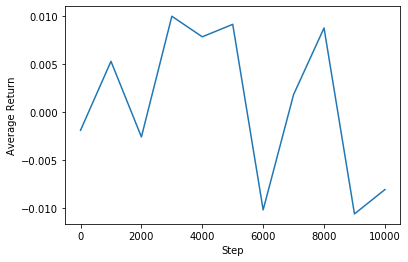

In [108]:
#@test {"skip": true}

steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.ylim()

In [76]:
returns

[-0.015218849]